In [2]:
# pip install polytope
# pip install pypoman

import numpy as np
from sympy.geometry import Point
import matplotlib.pyplot as plt
from pypoman import compute_polytope_halfspaces
import polytope
from scipy.spatial import ConvexHull

First we implement fundamental functions (matrix operations, linear akgebra methods, etc.).

In [3]:
def setdiff2d_iter(arr1, arr2):
    delta = set(map(tuple, arr2))
    return np.fromiter((x for xs in arr1 if tuple(xs) not in delta for x in xs), dtype=int).reshape(-1, arr1.shape[-1])

def is_linear_dependend(point_start, point_end, point_test):
    p_start = Point(point_start)
    p_end = Point(point_end)
    p_test = Point(point_test)
    return Point.is_collinear(p_start, p_end, p_test)

def distance_to_origin(facet, origin):
    #do stuff
    return True
    
def is_reflexive():
    #do stuff
    return True

Let's construct a reflexive 2D polytope (taken from the book "The Calabi–Yau Landscape", page 44)

In [4]:
V = np.array([[0, -1], [-1, 0], [-1, 2], [1, 0], [1, -1]])


Pypoman provides a form $0\le -Ax+b$

In [5]:
A, b = compute_polytope_halfspaces(V)

print(A)
print(b)

[[-0. -1.]
 [-1. -0.]
 [-1. -1.]
 [ 1.  1.]
 [ 1. -0.]]
[1. 1. 1. 1. 1.]


Polytope provides a form $Ax\le b$ which is equivalent to pypoman's form $0\le-Ax+b$

In [6]:
P = polytope.qhull(V)

print(P.A)
print(P.b)
#print(P.vertices)

[[ 0.70711  0.70711]
 [-1.       0.     ]
 [-0.70711 -0.70711]
 [ 1.       0.     ]
 [ 0.      -1.     ]]
[0.70711 1.      0.70711 1.      1.     ]


Scipy yields an array $[normal, offset]$ that describes $Ax+b\le0$ forming the hyperplane equation of the facet see [documentation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.ConvexHull.html)

In [7]:
hull = ConvexHull(V)
print(hull.equations)

[[-1.       0.      -1.     ]
 [ 0.70711  0.70711 -0.70711]
 [-0.70711 -0.70711 -0.70711]
 [ 1.       0.      -1.     ]
 [-0.      -1.      -1.     ]]


When using the negated form of pypoman's result, that is $Ax-b\le0$ then $b$ is the distance we are looking for.

The distances are defined in the hyperplane representation. The hyperplanes are given as $<u,v> \ge a$ where $u$ are points in the polytope lattice $M, v$ is a single point in the dual lattice $N$ and $a$ is the distance which is real number. If we just get the hyperplane representation then we automatically have the distances.

In [17]:
A, b = compute_polytope_halfspaces(V)
print(b)

[1. 1. 1. 1. 1.]


The fitness function consists of two parts.

The first term is IP(Delta)-1, where IP(Delta) = 1 if Delta satisfies IP and 0 otherwise, adds a penalty if Delta doesn’t satisfy the IP property.

The second term sum(ai-1), where ai are the hyperplane distances of each face, adds a penalty if the distances of all the hyper planes aren’t at a distance 1 from the origin.

In [19]:
V = np.array([[0, -1], [-1, 0], [-1, 2], [1, 0], [1, -1]])

A, b = compute_polytope_halfspaces(V)

def fitness(ip_count, distances):
    result = 0
    if ip_count > 1:
        result -= 1
    for d in distances:
        result -= abs(d-1)
    return result

print(fitness(1, b))

0.0


Some experimental stuff starts here:

In [10]:
import numpy as np
import polytope

# halfspace representation computed using `polytope`
# from the vertex representation given in the question
vertices = np.array([[0, -1], [-1, 0], [-1, 2], [1, 0], [1, -1]])
poly = polytope.qhull(vertices)
# first halfspace representation
A = np.array([
    [0, -1],
    [-1, 0],
    [-1, -1],
    [1, 1],
    [1, 0]])
b = np.array([1, 1, 1, 1, 1])
question_poly_1 = polytope.Polytope(A, b)
# second halfspace representation
A = np.array([
    [-0.70711, -0.70711],
    [-1, -0],
    [0.70711, 0.70711],
    [0, -1],
    [1, 0]])
b = np.array([0.70711, 1, 0.70711, 1, 1])

question_poly_2 = polytope.Polytope(A, b)
# check that all the above halfspace representations
# represent the same polytope
assert poly == question_poly_1, (poly, question_poly_1)
assert poly == question_poly_2, (poly, question_poly_2)

In [11]:
# check later wether we can adjust "enumerate_integral_points" such
# that it returns only points that lie within the polytope, i.e. we
# want to exclude points that lie on a facet
integral_points = polytope.polytope.enumerate_integral_points(P)

integral_points = integral_points.transpose()
integral_points = integral_points.astype(int)

# remove the original corner points
integral_points = setdiff2d_iter(integral_points, V)

# remove points located on a polygon facet
num_v_points = V.shape[0]
for v_point_idx in range(0, num_v_points - 1):
    point_start = V[v_point_idx]
    point_end = V[v_point_idx+1]

    num_i_points = integral_points.shape[0]
    for i_point_idx in range(0, num_i_points):
        if is_linear_dependend(point_start, point_end, integral_points[i_point_idx]):
            integral_points = np.delete(integral_points, i_point_idx, axis=0)
            break

print(integral_points)


[[0 0]]


In [12]:
inner_point = np.array([0,0]) # in this case it is the origin
fac1 = polytope.quickhull.Facet([[0, -1], [-1, 0]])
fac2 = polytope.quickhull.Facet([[-1, 2], [1, 0]])
fac3 = polytope.quickhull.Facet([[1, -1], [0, -1]])

d1 = polytope.quickhull.distance(inner_point, fac1)
d2 = polytope.quickhull.distance(inner_point, fac2)
d3 = polytope.quickhull.distance(inner_point, fac3)
print(d1)
print(d2)
print(d3)

[-0.70711]
[-0.70711]
[-1.]


Let's visualize our 2D polytope. For this purpose we use the [Polytope Library](https://github.com/tulip-control/polytope)

(0.7071067811865475, array([0., 0.]))


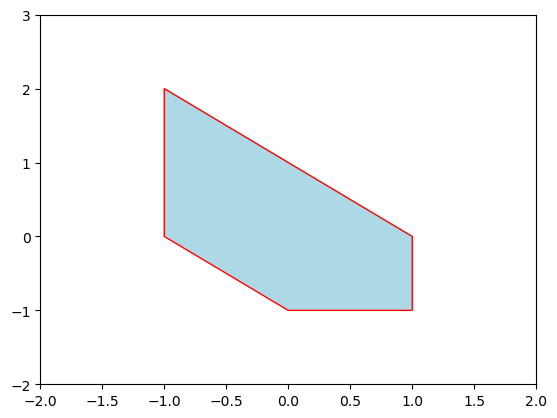

In [13]:

print(polytope.polytope.cheby_ball(P))

min_V = np.min(V, axis=0) #min val of each cols
min_x = min_V[0]
min_y = min_V[1]
max_V = np.max(V, axis=0) #max val of each cols
max_x = max_V[0]
max_y = max_V[1]

ax = P.plot(linestyle="solid", linewidth=1, color="lightblue", edgecolor="red")
ax.set_xlim([min_x-1, max_x+1])
ax.set_ylim([min_y-1, max_y+1])
plt.show()